credits: Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks by Arthur Juliani
### Using Q-Table
* For this we are going to solve the FrozenLake environment from the OpenAI gym. The FrozenLake environment consists of a 4x4 grid of blocks, each one either being the start block, the goal block, a safe frozen block, or a dangerous hole. 
* The objective is to have an agent learn to navigate from the start to the goal without moving onto a hole. At any given time the agent can choose to move either up, down, left, or right. The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose. As such, perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.
* In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.
* We make updates to our Q-table using something called the Bellman equation, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! In equation form, the rule looks like this:
#### Eq 1. Q(s,a) = r + γ(max(Q(s’,a’))
* This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state. Below is a Python walkthrough of the Q-Table algorithm implemented in the FrozenLake environment:

In [2]:
import gym
import numpy as np

In [3]:
env = gym.make('FrozenLake-v0')

[2017-09-08 21:08:35,924] Making new env: FrozenLake-v0


In [54]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        
        #Get new state and reward from environment
        #env.step(a) returns the next state s1 if action a is taken and the reward r for taking that action
        #and d where d is false or true, false means you are still in the game and true means 
        #game over , i.e you are either dead or you won
        s1,r,d,_ = env.step(a)
        
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)
    

In [55]:
print ("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.515


In [56]:
print ("Final Q-Table Values")
print (Q)

Final Q-Table Values
[[  1.70552794e-01   8.65840354e-03   1.24181187e-02   1.02616729e-02]
 [  3.00201087e-04   3.04262627e-03   1.23584083e-03   9.02429331e-02]
 [  1.20607623e-03   3.89015564e-02   1.62397715e-03   1.20854948e-02]
 [  2.54713905e-03   3.46516161e-04   3.36594289e-04   4.89234136e-02]
 [  2.41955253e-01   3.23948952e-04   4.82455573e-03   3.18669778e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.83965547e-04   1.98063941e-09   1.52423723e-03   1.44528941e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.67183761e-04   1.88288612e-03   8.14556928e-04   3.30287745e-01]
 [  1.64496309e-03   2.28956417e-01   3.06989080e-03   3.40118805e-03]
 [  7.72358438e-01   1.25353363e-03   3.52833046e-04   4.74257027e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.29897993e-05   0.00000000e+00   6.89723804e-01   4

### Using Neural Nets
* Now, there is one problem with q tables: tables are great, but they don’t really scale. While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.
* In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table. The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in equation 1 above.
#### Eq2. Loss = ∑(Q-target - Q)²

Below is the Tensorflow walkthrough of implementing our simple Q-Network:

In [6]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
env = gym.make('FrozenLake-v0')

[2017-09-10 21:42:44,546] Making new env: FrozenLake-v0


In [8]:
tf.reset_default_graph()

In [9]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [10]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.5035%


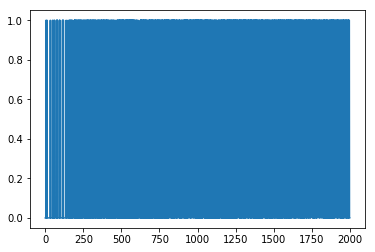

In [11]:
plt.plot(rList) ##total reward in that episode, 0 player died , 1 player won

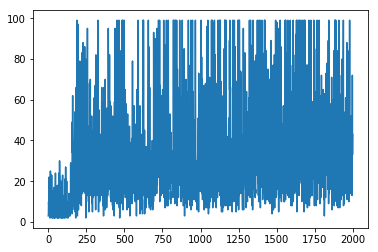

In [12]:
plt.plot(jList) ## no of steps taken in each episode

In [24]:
X=[]
for i,reward in enumerate(rList):
    if(reward==1):
        X.append(jList[i])

In [28]:
min(X),max(X) ## min and max steps taken to win 

(6, 99)